<a href="https://colab.research.google.com/github/trehansalil/food_delivery_estimation/blob/main/experimental_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import os
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [7]:
df = pd.read_csv("/content/drive/MyDrive/data_problem_1.csv")

In [8]:
df.shape

(237373, 7)

In [9]:
df.order_delivered_time = pd.to_datetime(df.order_delivered_time)
df.order_pickedup_time = pd.to_datetime(df.order_pickedup_time)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237373 entries, 0 to 237372
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   order_id              237373 non-null  object        
 1   R_Lon                 237373 non-null  float64       
 2   R_Lat                 237373 non-null  float64       
 3   C_Lon                 237373 non-null  float64       
 4   C_Lat                 237373 non-null  float64       
 5   order_pickedup_time   237373 non-null  datetime64[ns]
 6   order_delivered_time  237373 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(4), object(1)
memory usage: 12.7+ MB


In [6]:
df['order_id'].nunique()

237373

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
df['service_provider'] = df['order_id'].apply(lambda x: x.split("_")[1])

df['ETA'] = df.order_delivered_time - df.order_pickedup_time
df['ETA'] = df['ETA'].dt.total_seconds() / 60

# Extract the month from the order_pickedup_time column
df['month'] = df['order_pickedup_time'].dt.month

# Extract the day of the week from the order_pickedup_time column
df['day_of_week'] = df['order_pickedup_time'].dt.dayofweek

# Extract the hour of the day from the order_pickedup_time column
df['hour_of_day'] = df['order_pickedup_time'].dt.hour



In [12]:
import math

def haversine_distance(lat1, lon1, lat2, lon2):
  """
  Calculate the great circle distance between two points on the earth (specified in decimal degrees).
  """
  # convert decimal degrees to radians
  lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

  # haversine formula
  dlat = lat2 - lat1
  dlon = lon2 - lon1
  a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
  c = 2 * math.asin(math.sqrt(a))
  r = 6371  # Radius of earth in kilometers. Use 3956 for miles
  return c * r

# Calculate the aerial distance for each row in the DataFrame

df['travel_distance'] = df.apply(lambda x: haversine_distance(x['R_Lat'], x['R_Lon'], x['C_Lat'], x['C_Lon']), axis=1)



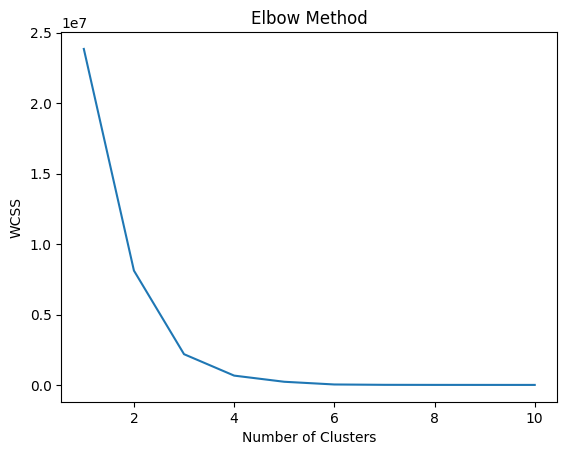

In [13]:
# prompt: Write the code to identify geographical regions based on these columns (R_Lon, R_Lat) , (C_Lon, C_Lat) using geospatial clustering

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Extract the longitude and latitude columns
X = pd.concat([df.loc[:,['R_Lon', 'R_Lat']].rename(columns = {"R_Lon": 'Lon', "R_Lat": 'Lat'}),
           df.loc[:,['C_Lon', 'C_Lat']].rename(columns = {"C_Lon": 'Lon', "C_Lat": 'Lat'})], axis=0).reset_index(drop=True)

# Determine the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()



In [14]:
# Create a KMeans model with the optimal number of clusters
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X)

# Assign cluster labels to each data point
df['R_region'] = kmeans.labels_[:df.shape[0]]

df['C_region'] = kmeans.labels_[df.shape[0]: ]

df['diff_region_delivery'] = df['R_region'] != df['C_region']

df['diff_region_delivery'] = df['diff_region_delivery'].astype(int)


In [15]:
df.drop(columns = ['order_id', 'R_Lon', 'R_Lat',	'C_Lon',	'C_Lat',	'order_pickedup_time',	'order_delivered_time'], inplace=True)

In [16]:
df

,service_provider,ETA,month,day_of_week,hour_of_day,travel_distance,R_region,C_region
0,ZMT,26.733333,4,5,9,2.242045,0,0
1,ZMT,21.633333,4,5,11,1.632941,0,0
2,ZMT,18.183333,4,5,14,0.906626,0,0
3,ZMT,32.966667,4,5,16,1.562127,0,0
4,ZMT,22.250000,4,6,7,3.775236,0,0
...,...,...,...,...,...,...,...,...
237368,ZMT,29.883333,9,6,16,3.371266,0,0
237369,ZMT,14.266667,9,6,17,2.471663,2,2
237370,ZMT,21.266667,9,6,17,1.958820,1,1
237371,ZMT,19.016667,9,6,17,1.446523,1,1


<Axes: xlabel='hour_of_day', ylabel='ETA'>

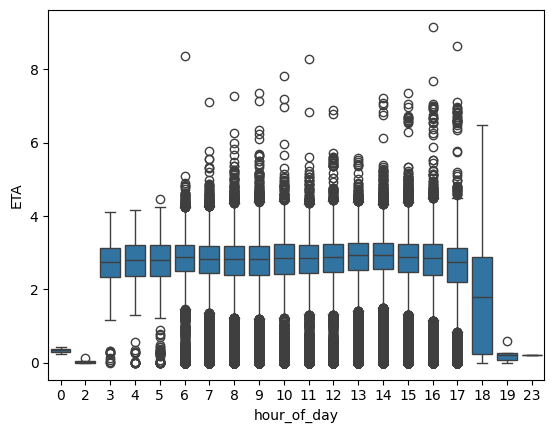

In [16]:
sns.boxplot(y=np.log1p(df['ETA']), x=df['hour_of_day'])

1. Problem Statement
======================
Ensuring timely delivery of food orders is critical as customers expect swift service. To enhance service efficiency, we aim to devise an ETA prediction model. This model should estimate the time required for order delivery (ETA) based on factors such as time of day, travel distance, and potentially varying conditions across different geographical regions.

2. Data
======================
Included in the provided CSV file is pan-India data detailing order pickup and drop-off locations, along with corresponding timestamps. The columns include R_{lon,lat}, C_{lon,lat}, order_{pickedup,delivered}_time, respectively.

3. Goal
======================
This goal comprises two main objectives:

Identify ETA distributions that may correlate with factors such as time of day, travel distance (aerial distance may suffice), and geographical regions.
Develop a predictive model to estimate ETA given the time of day and expected travel distance for incoming orders.
Applicants are expected to address at least one of these objectives. They are free to utilize any open-source tool or library in any programming language, although solutions in Python, R, Java, or C++ are preferred for easier evaluation. While conducting the analysis, assumptions may be made to simplify or clarify the problem, but they must be clearly justified.

In addition to the solution, applicants are required to submit a concise report (1 or 2 pages) outlining their approach, assumptions, and any potential improvements with additional time.

<Axes: xlabel='diff_region_delivery', ylabel='ETA'>

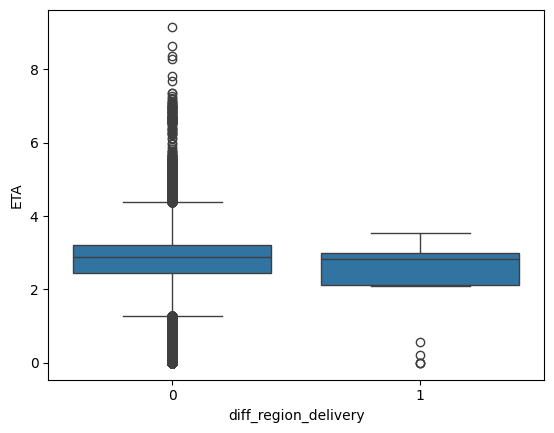

In [ ]:
sns.boxplot(y=np.log1p(df['ETA']), x=df['diff_region_delivery'])

<Axes: xlabel='service_provider', ylabel='ETA'>

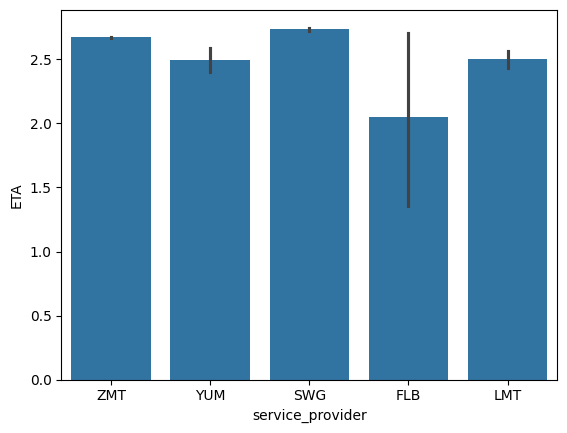

In [17]:
sns.barplot(y=np.log1p(df['ETA']), x=df['service_provider'])

<Axes: xlabel='service_provider', ylabel='ETA'>

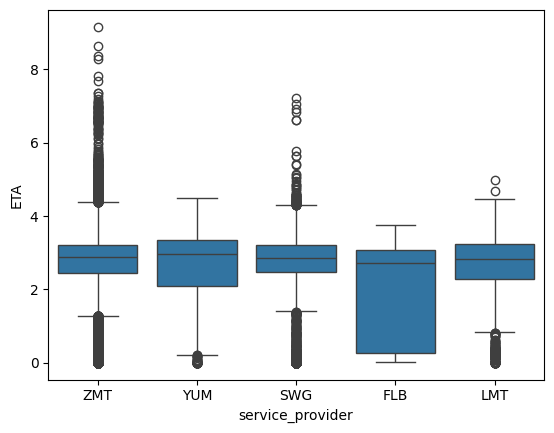

In [ ]:
sns.boxplot(y=np.log1p(df['ETA']), x=df['service_provider'])

<Axes: xlabel='travel_distance', ylabel='ETA'>

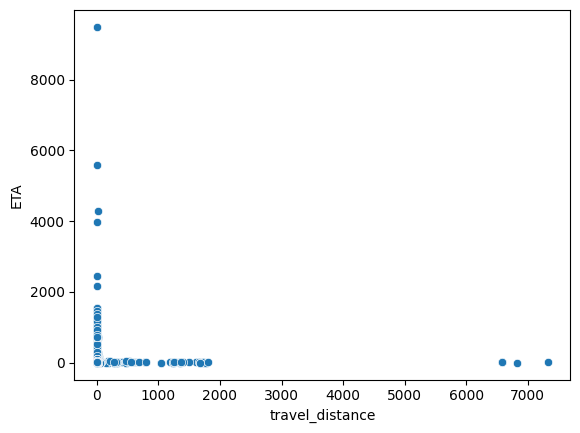

In [ ]:
sns.scatterplot(x=df['travel_distance'], y=df['ETA'], )

In [17]:
df['_is_prime_partner'] = df['service_provider'].isin(['ZMT', 'SWG'])

In [18]:

df['hour_of_day'].unique()

array([ 9, 11, 14, 16,  7,  8, 13, 15, 10, 17, 12,  5,  6, 18,  4,  3,  2,
       19, 23,  0], dtype=int32)

In [19]:
df['Time_of_day'] = 'day'

In [20]:
df.loc[(df['hour_of_day']>18) & (df['hour_of_day']<6), 'Time_of_day'] = 'night'

In [21]:
cat_cols = ['service_provider', 'month',	'day_of_week',	'hour_of_day', 'Time_of_day', 'R_region',	'C_region', 'diff_region_delivery', '_is_prime_partner']

num_cols = ['travel_distance']

target_col = 'ETA'

In [22]:
df['travel_distance_log'] = np.log1p(df['travel_distance'])
df['ETA_log'] = np.log1p(df['ETA'])

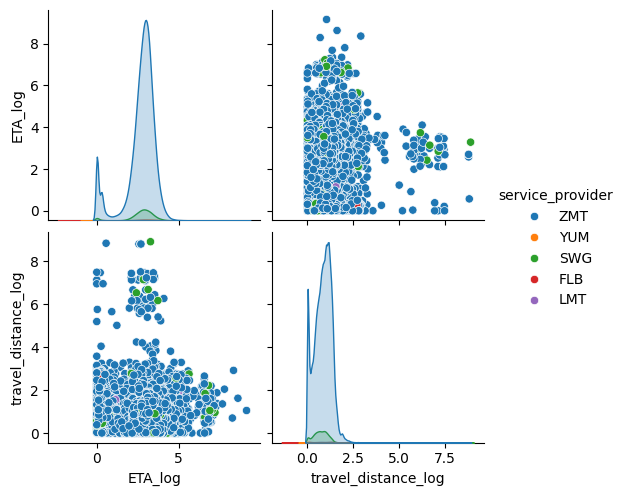

In [25]:
sns.pairplot(data=df[['ETA_log', 'travel_distance_log', 'service_provider']], hue='service_provider')
plt.show()

In [29]:
df.columns

Index(['service_provider', 'ETA', 'month', 'day_of_week', 'hour_of_day',
       'travel_distance', 'R_region', 'C_region', '_is_prime_partner',
       'Time_of_day', 'travel_distance_log', 'ETA_log'],
      dtype='object')

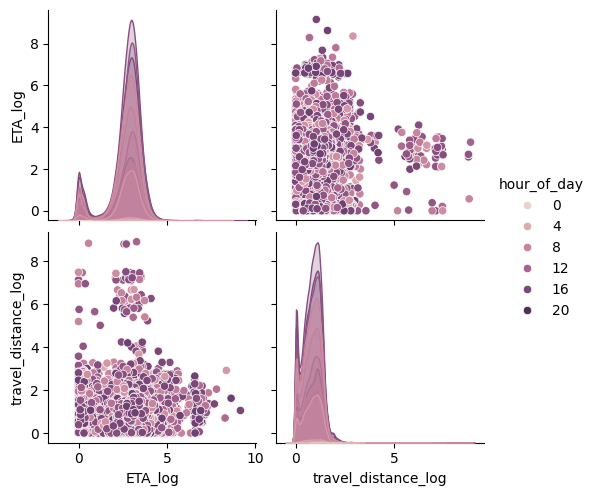

In [30]:
sns.pairplot(data=df[['ETA_log', 'travel_distance_log', 'hour_of_day']], hue='hour_of_day')
plt.show()

In [36]:
df.columns

Index(['service_provider', 'ETA', 'month', 'day_of_week', 'hour_of_day',
       'travel_distance', 'R_region', 'C_region', '_is_prime_partner',
       'Time_of_day', 'travel_distance_log', 'ETA_log'],
      dtype='object')

In [33]:
df['_is_prime_partner'] = df['_is_prime_partner'].astype(int)

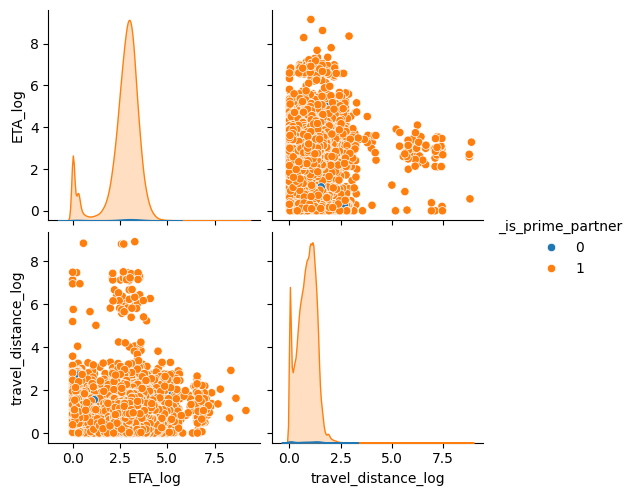

In [35]:
sns.pairplot(data=df[['ETA_log', 'travel_distance_log', '_is_prime_partner']], hue='_is_prime_partner')
plt.show()

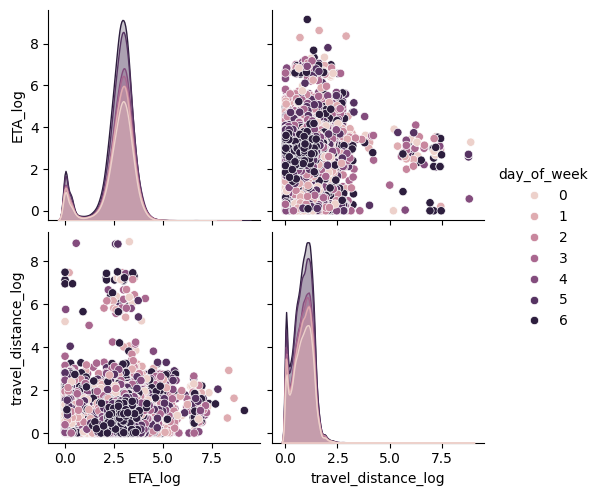

In [31]:
sns.pairplot(data=df[['ETA_log', 'travel_distance_log', 'day_of_week']], hue='day_of_week')
plt.show()

<ipython-input-22-4615932396f8>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log1p(df['travel_distance']))


<Axes: xlabel='travel_distance', ylabel='Density'>

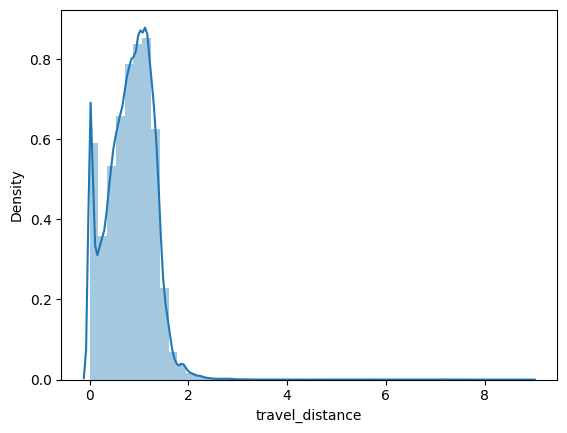

In [22]:
sns.distplot(np.log1p(df['travel_distance']))

<ipython-input-21-b122d44e3192>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log1p(df['ETA']))


<Axes: xlabel='ETA', ylabel='Density'>

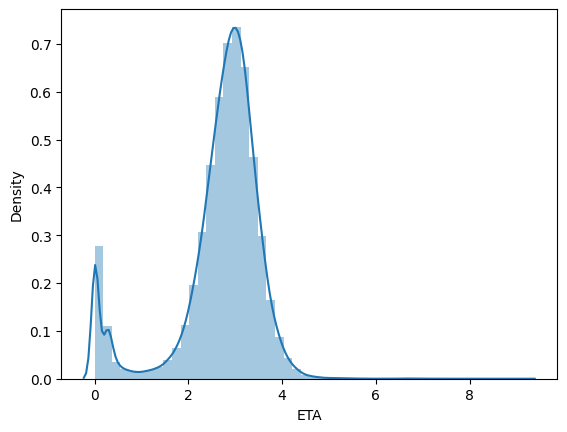

In [21]:
sns.distplot(np.log1p(df['ETA']))

## Base Model

In [26]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.9/485.9 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.9/21.9 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 51.4

In [23]:
from pycaret.datasets import get_data
from pycaret.regression import *

ModuleNotFoundError: No module named 'pycaret'

In [24]:
ohe_data = pd.get_dummies(data=df.drop(columns=['ETA_log']), columns=['service_provider', 'R_region', 'C_region', 'Time_of_day'])

for i in ['_is_prime_partner',	'service_provider_FLB',	'service_provider_LMT',
          'service_provider_SWG',	'service_provider_YUM',	'service_provider_ZMT',	'R_region_0',	'R_region_1',	'R_region_2',	'C_region_0',	'C_region_1',	'C_region_2',	'Time_of_day_day']:
  ohe_data[i] = ohe_data[i].astype(int)

In [38]:
from sklearn.decomposition import PCA

In [25]:
x = ohe_data.drop(columns=['ETA'])
y = ohe_data['ETA']

In [49]:
# Apply PCA
pca = PCA(n_components=2)  # Specify the number of components
X_pca = pca.fit_transform(x)

# # Create a DataFrame with PCA-transformed features
X_pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

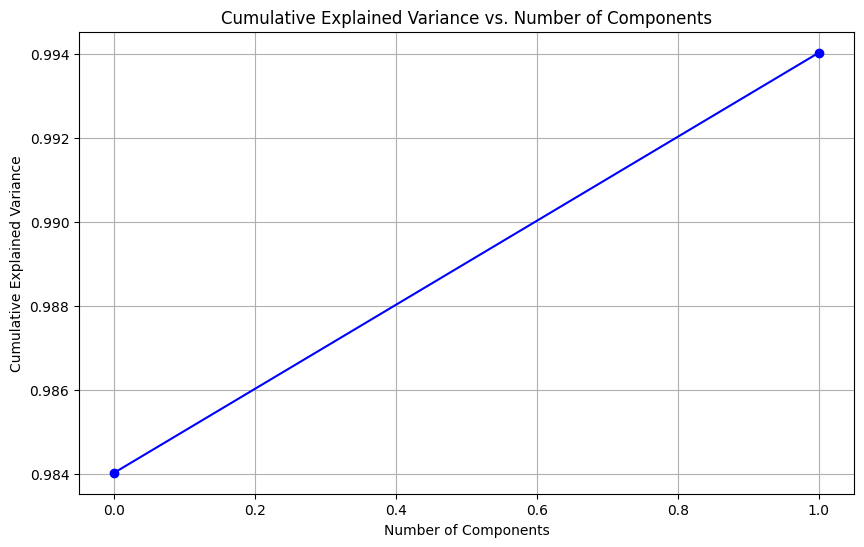

In [48]:
# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [30]:
from pycaret.datasets import get_data
from pycaret.regression import *

# Initialize the regression setup
regression_setup = setup(df.drop(columns=['ETA_log']), target=target_col, session_id=123)

# Compare different regression models
best_model = compare_models()

# Create the best model
final_model = create_model(best_model)

# Tune the hyperparameters of the model
tuned_model = tune_model(final_model)

# Evaluate the model
evaluate_model(tuned_model)

# Predictions
predictions = predict_model(tuned_model)

# Finalize the model for deployment
final_model_for_deployment = finalize_model(tuned_model)

,Description,Value
0,Session id,123
1,Target,ETA
2,Target type,Regression
3,Original data shape,"(237373, 11)"
4,Transformed data shape,"(237373, 15)"
5,Transformed train set shape,"(166161, 15)"
6,Transformed test set shape,"(71212, 15)"
7,Numeric features,7
8,Categorical features,2
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,04:49:25
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,9.4447,1186.8153,29.1453,0.0082,0.9654,16.7793,0.9660
ridge,Ridge Regression,9.4447,1186.8151,29.1453,0.0082,0.9654,16.7798,0.3970
br,Bayesian Ridge,9.4451,1186.8294,29.1454,0.0082,0.9656,16.7921,0.4580
lar,Least Angle Regression,9.4521,1187.3120,29.1575,0.0070,0.9653,16.8243,0.4010
huber,Huber Regressor,9.2371,1190.2250,29.2095,0.0027,0.9387,15.1129,2.4540
en,Elastic Net,9.5728,1190.3743,29.2150,0.0023,0.9727,16.8803,0.6480
lasso,Lasso Regression,9.6172,1191.6710,29.2410,-0.0000,0.9744,16.8930,0.6310
llar,Lasso Least Angle Regression,9.6172,1191.6710,29.2410,-0.0000,0.9744,16.8930,0.4210
omp,Orthogonal Matching Pursuit,9.6182,1191.7284,29.2421,-0.0001,0.9744,16.8931,0.5750
knn,K Neighbors Regressor,10.5302,1391.3639,33.1007,-0.4050,0.9819,16.1869,2.0100


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [42]:
len(x.columns)

18

In [54]:
xtrain, xtest, ytrain, ytest = train_test_split(X_pca_df, y,
                                                test_size=0.20,
                                                random_state=0)

xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain,
                                                test_size=0.10,
                                                random_state=0)

# creating the LSTM neural network model
from keras.models import Sequential
from keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape= (xtrain.shape[1], 1)))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 2, 256)            264192    
                                                                 
 lstm_20 (LSTM)              (None, 2, 128)            197120    
                                                                 
 lstm_21 (LSTM)              (None, 2, 64)             49408     
                                                                 
 lstm_22 (LSTM)              (None, 64)                33024     
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 25)                825       
                                                                 
 dense_14 (Dense)            (None, 1)                

In [56]:
# training the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(xtrain, ytrain, batch_size=600, epochs=15, validation_data=(xval, yval))

Epoch 1/15
285/285 [==============================] - 12s 14ms/step - loss: 1255.7914 - val_loss: 2221.4473
Epoch 2/15
285/285 [==============================] - 3s 11ms/step - loss: 1217.4644 - val_loss: 2217.4065
Epoch 3/15
285/285 [==============================] - 2s 8ms/step - loss: 1217.5040 - val_loss: 2216.3105
Epoch 4/15
285/285 [==============================] - 2s 8ms/step - loss: 1217.5232 - val_loss: 2216.6465
Epoch 5/15
285/285 [==============================] - 2s 9ms/step - loss: 1217.1096 - val_loss: 2215.8452
Epoch 6/15
285/285 [==============================] - 2s 8ms/step - loss: 1217.4086 - val_loss: 2216.3027
Epoch 7/15
285/285 [==============================] - 3s 11ms/step - loss: 1216.8461 - val_loss: 2216.5303
Epoch 8/15
285/285 [==============================] - 2s 8ms/step - loss: 1217.0502 - val_loss: 2216.2407
Epoch 9/15
285/285 [==============================] - 2s 8ms/step - loss: 1216.9220 - val_loss: 2216.4990
Epoch 10/15
285/285 [=====================

In [29]:
df.drop(columns=['ETA_log']).columns

Index(['service_provider', 'ETA', 'month', 'day_of_week', 'hour_of_day',
       'travel_distance', 'R_region', 'C_region', 'travel_distance_log',
       'Time_of_day', '_is_prime_partner'],
      dtype='object')